In [1]:
import numpy as np
import cv2
import os
import abc
import pyaml

import typing as T

from dataclasses import dataclass
from pathlib import Path
from imageio import imread
from skimage import filters
from skimage.transform import rescale
from scipy import stats
from tqdm.auto import tqdm
from matplotlib import pyplot as plt

from skimage.util import view_as_windows

In [2]:

@dataclass
class Args:
    root:               Path      = Path("/home/korsch/Data/DATASETS/moths")
    location:           str       = "eu_moths/uncropped/ORIGINAL"
    
    pad:                bool      = False
    extensions:         tuple     = ("jpg", "png", "jpeg")
    
    sigma:              float     = 5
    equalize:           bool      = True
    scale:              float     = 0.1
    min_size:           float     = 800
    block_size_scale:   float     = 0.1
    enlarge:            float     = 0.01
    
        
    kernel_size:        int       = 5
    dilate_iterations:  int       = 1
    open_close:         bool      = True
    
    # otsu cv2otsu gauss_local
    thresholding:       str       = "gauss_local"
    
    
    def __str__(self):
        return pyaml.dump(dict(Arguments=self.__dict__), sort_dicts=False)
    


In [3]:
def _is_image(im_name, extensions):
    return any([im_name.lower().endswith(ext.lower()) for ext in extensions])

def get_images(path, extensions=[], sort=True):
    result = []
    
    for root, dirnames, fnames in os.walk(path):
        
        result.extend([Path(root) / fname for fname in fnames if _is_image(fname, extensions)])

    if sort:
        result = sorted(result)
    
    return result

def int_tuple(values):
    return tuple(map(int, values))

def get_maxvalue(im: np.ndarray):
    max_value = { dt().dtype.name: value for dt, value in
        [(np.uint8, 255), 
        (np.float32, 1.0), 
        (np.float64, 1.0)]
    }.get(im.dtype.name)
    assert max_value is not None, f"Unsupported {im.dtype=}"
    return max_value

def random_color(rnd: np.random.RandomState = None):
    rnd = rnd or np.random.RandomState()
    c = rnd.randint(0, 255, size=(3,))
    return int_tuple(c)

def histogram(im: np.ndarray, bins: int = 256, cumulative: bool = False):
    hist, edges = np.histogram(im, bins=bins, density=False)
    hist = hist / np.multiply(*im.shape)
    return np.cumsum(hist) if cumulative else hist


In [4]:


def _im_mean_std(integral, integral_sq, bbox=None):
    if bbox is None:
        arr_sum = integral[-1, -1]
        arr_sum_sq = integral_sq[-1, -1]
        N = (integral.shape[0] - 1) * (integral.shape[1] - 1)
    else:
        (x0, y0), (x1, y1) = bbox
        A, B, C, D = (y0,x0), (y1,x0), (y0,x1), (y1,x1)
        arr_sum = integral[D] + integral[A] - integral[B] - integral[C]
        arr_sum_sq = integral_sq[D] + integral_sq[A] - integral_sq[B] - integral_sq[C]
        
        N = (x1-x0) * (y1-y0)
        
    arr_mean = arr_sum / N
    arr_std  = np.sqrt((arr_sum_sq - (arr_sum**2) / N) / N)
    
    return arr_mean, arr_std, N

def _check_ratio(bbox, threshold=0.25):
    (x0, y0), (x1, y1) = bbox
    h, w = y1-y0, x1-x0
    
    ratio = min(h, w) / max(h, w)
    return ratio >= threshold

def _check_area(bbox, imshape, minarea=4e-4, maxarea=1/9):
    
    (x0, y0), (x1, y1) = bbox
    h, w = y1-y0, x1-x0
    H, W = imshape
    area_ratio = (h*w) / (H*W)
    
    return minarea <= area_ratio <= maxarea

def _rescale(im: np.ndarray, min_size: int, 
             min_scale: float = -1,
             interpolation = cv2.INTER_LINEAR
            ):
    H, W = im.shape
    _scale = min_size / min(H, W)
    scale = max(min_scale, min(1, _scale))
    size = int(W * scale), int(H * scale)
    
    return cv2.resize(im, dsize=size, interpolation=interpolation)

def _mask_border(im: np.ndarray, area_thresh: float = 0.50) -> None:
    
    contours, hierarchy = cv2.findContours(im, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    
    ### Find smallest contour with an area above the threshold
    imsize = im.shape[0] * im.shape[1]
    selected = None
    for cont in contours:
        area = cv2.contourArea(cont) / imsize
        if area >= area_thresh and (selected is None or selected[0] > area):
            selected = (area, cont)

    ### we found a counter enclosing the white screen, so mask it accordingly
    if selected is not None:
        area, cont = selected

        hull = cv2.convexHull(cont, False)
        mask = np.zeros(im.shape, dtype=np.uint8)
        # here we have a mask with 1's inside the contour
        cv2.drawContours(mask, [hull], 0, color=1, thickness=-1)

        im[:] = im * mask

def _enlarge(bboxes, enlarge: int):
    if enlarge <= 0:
        return bboxes
    
    enlarged = []
    for bbox in bboxes:
        (x0, y0), (x1, y1) = bbox

        x0, y0 = max(x0 - enlarge, 0), max(y0 - enlarge, 0)
        x1, y1 = x1 + enlarge, y1 + enlarge

        enlarged.append([(x0, y0), (x1, y1)])
    
    return enlarged

def _gaussian(im: np.ndarray, sigma: float = 5.0):
    return filters.gaussian(im, sigma=sigma, preserve_range=True).astype(im.dtype)

def _high_pass(im: np.ndarray, sigma: float = 5.0, *, return_low_pass: bool = False):
    max_value = get_maxvalue(im)
    dtype = im.dtype
    
    im = im.astype(np.float32) / max_value
    
    gauss = _gaussian(im, sigma=sigma)
    high_pass = abs((im - gauss) * max_value).astype(dtype)
    
    return (high_pass, gauss) if return_low_pass else high_pass    
    

In [5]:
ThreshReturn = T.Tuple[float, T.Optional[np.ndarray]]

In [6]:
class BaseThresholder(abc.ABC):
    
    def __init__(self, *args, **kwargs):
        super().__init__()
    
    def __call__(self, im: np.ndarray) -> np.ndarray:
        assert im.ndim == 2, "Should be an image with one channel!"
        
        max_value = get_maxvalue(im)
        
        thresh, bin_im = self.threshold(im)
        
        if bin_im is None:
            bin_im = ((im > thresh) * max_value).astype(im.dtype)
        
        return max_value - bin_im
    
    @abc.abstractmethod
    def threshold(self, im: np.ndarray) -> ThreshReturn:
        pass

class OtsuTresholder(BaseThresholder):
    
    def __init__(self, *, use_cv2: bool = False, **kwargs):
        super().__init__(**kwargs)
        self._use_cv2 = use_cv2
    
    def threshold(self, im: np.ndarray) -> ThreshReturn:
        if self._use_cv2:
            return cv2.threshold(im, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
            
        thresh = filters.threshold_otsu(im)
        return thresh, None
    

class GaussLocalTresholder(BaseThresholder):
    
    def __init__(self, *, block_size_scale: float = 0.1, do_padding: bool = False, **kwargs):
        super().__init__(**kwargs)
        self._do_padding = do_padding
        self._block_size_scale = block_size_scale
    
    def threshold(self, im: np.ndarray) -> ThreshReturn:
        # make block size an odd number
        block_size = min(im.shape) * self._block_size_scale // 2 * 2 + 1
        
        if self._do_padding:
            pad = int(block_size * 0.1)
            im = np.pad(im, [(pad, pad), (pad, pad)])
            
        print(f"using blocksize {block_size}")
        thresh = filters.threshold_local(im, 
                                         block_size=block_size,
                                         mode="constant",
                                        )
        return thresh, None

class CustomTresholder(BaseThresholder):
    
    def __init__(self, *, window_size: int = 30, sigma: float = 5.0, **kwargs):
        super().__init__(**kwargs)
        self._window_size = window_size
        self._sigma = sigma
        
    def threshold(self, im: np.ndarray) -> ThreshReturn:
        
        h, w = im.shape
        
        #axs[0].imshow(im, cmap=plt.cm.gray)
        size = (self._window_size, self._window_size)
        step = self._window_size // 2
        bg = view_as_windows(im, size, step=step).mean((-1, -2))
        bg = cv2.resize(bg, (w, h), interpolation=cv2.INTER_CUBIC)
        diff_im = abs(bg - im) 
        edges, gaussIm = _high_pass(im, sigma=(self._window_size - 1)/4, return_low_pass=True)
        
        if self._sigma >= 1:
            diff_im = _gaussian(diff_im, sigma=self._sigma)
            edges = _gaussian(edges, sigma=self._sigma)
        
        
        thresh = edges.mean()
        print(thresh)
        bin_im = (edges <= thresh) * 255
        bin_im = bin_im.astype(np.uint8)
        
#         fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(32,24))
#         fig.suptitle("BG and Diff-Image")
#         axs[0,0].imshow(bg, cmap=plt.cm.gray)
#         axs[0,1].imshow(diff_im, cmap=plt.cm.gray)
#         axs[1,0].imshow(gaussIm, cmap=plt.cm.gray)
#         axs[1,1].imshow(edges, cmap=plt.cm.gray)
        
        return thresh, bin_im


THRESHOLDERS = dict(
    otsu=OtsuTresholder,
    gauss_local=GaussLocalTresholder,
    bg_fg=CustomTresholder,
)

5.1827537e-05 0.0028296877 0.924336
10.0 31


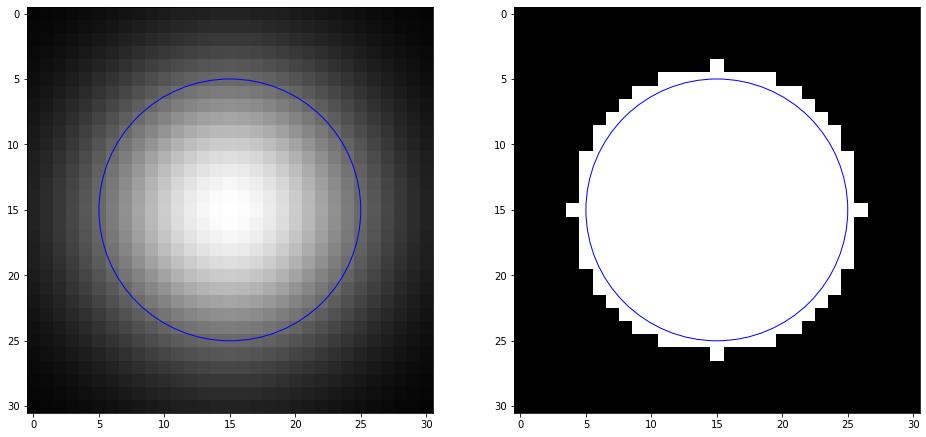

In [120]:
size = 31
eps = 1 / size**2
sigma = (size - 1) / 4

im = np.zeros((size, size), dtype=np.float32)
im[size//2, size//2] = 1.0

im2 = _gaussian(im, sigma=sigma)
print(im2.min(), im2.max(), im2.sum())
im2 /= im2.sum()
binary = (im2 > eps).astype(np.float32)

fig, axs = plt.subplots(ncols=2, figsize=(16,9))

axs[0].imshow(im2, vmin=0.0, vmax=im2.max(), cmap=plt.cm.gray)
axs[1].imshow(binary, vmin=0.0, vmax=1.0, cmap=plt.cm.gray)

contours, _ = cv2.findContours((binary * 255).astype(np.uint8), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

ax: plt.Axes = axs[1]
for cont in contours:
    mid, (r0, r1), angle = cv2.fitEllipse(cont)
    radius = min(r0, r1) // 2
    print(radius, size)
    axs[1].add_patch(plt.Circle(mid, radius, fill=False, edgecolor="blue"))
    axs[0].add_patch(plt.Circle(mid, radius, fill=False, edgecolor="blue"))

plt.show()
plt.close()

In [35]:
def simple_detector(im: np.ndarray):
    
    # Setup SimpleBlobDetector parameters.
    params = cv2.SimpleBlobDetector_Params()

    # Change thresholds
    params.minThreshold = 10
    params.maxThreshold = 200


    # Filter by Area.
#     params.filterByArea = True
#     params.minArea = 1500

    # Filter by Circularity
    params.filterByCircularity = True
    params.minCircularity = 0.1

    # Filter by Convexity
    params.filterByConvexity = True
    params.minConvexity = 0.87

    # Filter by Inertia
    params.filterByInertia = True
    params.minInertiaRatio = 0.01

    # Create a detector with the parameters
    # OLD: detector = cv2.SimpleBlobDetector(params)
    detector = cv2.SimpleBlobDetector_create(params)
    keypoints = detector.detect(im)
    print(keypoints)
    _im = np.repeat(np.expand_dims(im, axis=2), 3, axis=2)
    im_with_keypoints = cv2.drawKeypoints(_im, keypoints, np.array([]), 
                                          random_color(), cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
    
    fig, ax = plt.subplots(figsize=(16,9))
    
    ax.imshow(im_with_keypoints)
    
    plt.show()
    plt.close()

In [50]:
def _crop(im, rel_bbox):
    (x0,y0), (x1,y1) = rel_bbox
    h, w = im.shape
    return im[int(y0*h):int(y1*h), int(x0*w):int(x1*w)]

def _split_bbox(bbox, im: np.ndarray, rescale_size, detector, bin_image=None):
    (x0,y0), (x1,y1) = bbox
    _h, _w = rescale_size
    
    rel_bbox = (x0 / _w, y0 / _h), (x1 / _w, y1 / _h)
    
    orig_crop = _crop(im, rel_bbox)
    
    simple_detector(orig_crop)   
#     images, detections = detector(orig_crop)
    
#     im2, im3 = _plot_detections(orig_crop, *detections)
    
#     #crop_edges = _high_pass(orig_crop, sigma=15)
#     fig, axs = plt.subplots(ncols=3, figsize=(16,9))
#     axs[0].imshow(orig_crop, cmap=plt.cm.gray)
#     axs[1].imshow(im2, cmap=plt.cm.gray)
#     axs[2].imshow(im3, cmap=plt.cm.gray)

#     plt.show()
#     plt.close()

In [51]:
def _imshow(spec, im, *, title=None, cmap=plt.cm.gray):
    ax = plt.subplot(spec)
    ax.axis("off")
    ax.imshow(im, cmap=cmap)
    if title is not None:
        ax.set_title(title)
    return ax


def _plot_detections(im: np.ndarray, bboxes, inds, means_stds = None):
    
    
    im_pos = np.repeat(np.expand_dims(im, axis=2), 3, axis=2)
    im_neg = np.repeat(np.expand_dims(im, axis=2), 3, axis=2)

    for j, (bbox, (mean, std, ttest_res)) in enumerate(zip(bboxes, means_stds)):
        xy0, xy1 = bbox
        c = random_color()
        _bbox_im = im_pos if j in inds else im_neg

        cv2.rectangle(_bbox_im, xy0, xy1, c, 2)
        cv2.putText(_bbox_im,    
                    text=f"{mean:.2f} | {std:.2f}",
                    org=(xy0[0], int(xy0[1] - 5)),
                    fontFace=cv2.FONT_HERSHEY_SCRIPT_SIMPLEX,
                    fontScale=.7,
                    color=(0,0,255),
                    thickness=2,
                   )
    return im_pos, im_neg

def main(args: Args, N: int = 5):
    image_folder = Path(args.root) / args.location
    ims = get_images(image_folder, extensions=args.extensions)
    ims = np.random.choice(ims, size=N, replace=False)
    
    detector = Detector(
        scale_min_size=args.min_size,
        scale_min_scale=args.scale,
        
        pre_sigma=args.sigma,
        pre_equalize=args.equalize,
        
        dilate_iterations=args.dilate_iterations,
        open_close=args.open_close,
        kernel_size=args.kernel_size,
        
        post_enlarge=args.enlarge,
    
        # thresholder arguments
        thresh_type=args.thresholding,
        block_size_scale=args.block_size_scale,
        do_padding=args.pad,
        
        sigma=5,
        window_size=30
    )
    
    for i, im_path in enumerate(tqdm(ims)):
        orig = cv2.imread(str(im_path), cv2.IMREAD_COLOR)

        orig = cv2.cvtColor(orig, cv2.COLOR_RGB2GRAY)

        images, detections = detector(orig)

        im, bin_im, post_bin_im = images
        bboxes, inds, means_stds = detections
        
        im2, im3 = _plot_detections(im, *detections)
    
        for j in inds:
            _split_bbox(bboxes[j], orig, rescale_size=im.shape, detector=detector, bin_image=post_bin_im)

        grid = plt.GridSpec(nrows=3, ncols=6)
        fig = plt.figure(figsize=(16,12))
        
        _imshow(grid[0, 0:2],          im,             title="Input")
        _imshow(grid[0, 2:4],          bin_im,         title="Binarized")
        _imshow(grid[0, 4:6],          post_bin_im,    title="Binarized (postprocessed)")
        _imshow(grid[1:, :3],          im2,            title="Detections")

        _imshow(grid[1:, 3:],          im3,            title="Removed Detections")

        plt.tight_layout()
        plt.show()
        plt.close()
        

Arguments:
  root: /home/korsch/Data/DATASETS/moths
  location: brehm/2021-06-22_Weinschale-Ziegenhain
  pad: false
  extensions:
    - jpg
    - png
    - jpeg
  sigma: -3
  equalize: false
  scale: 0.1
  min_size: 800
  block_size_scale: 0.2
  enlarge: 0.01
  kernel_size: 5
  dilate_iterations: 3
  open_close: true
  thresholding: bg_fg



  0%|          | 0/3 [00:00<?, ?it/s]

3.755809375
[<KeyPoint 0x7f1ea1d5e3f0>, <KeyPoint 0x7f1ea1d5e570>, <KeyPoint 0x7f1eac0a5f60>, <KeyPoint 0x7f1eac0a5060>, <KeyPoint 0x7f1eac0a5360>, <KeyPoint 0x7f1eac0a5330>, <KeyPoint 0x7f1eac0a5300>, <KeyPoint 0x7f1eac0a5120>, <KeyPoint 0x7f1eac0a5090>, <KeyPoint 0x7f1eac0a5690>, <KeyPoint 0x7f1eac0a5810>, <KeyPoint 0x7f1eac0a5870>, <KeyPoint 0x7f1eac0a5750>, <KeyPoint 0x7f1eac0a56c0>, <KeyPoint 0x7f1eac0a5780>, <KeyPoint 0x7f1eac0a5660>, <KeyPoint 0x7f1eac0a5630>]


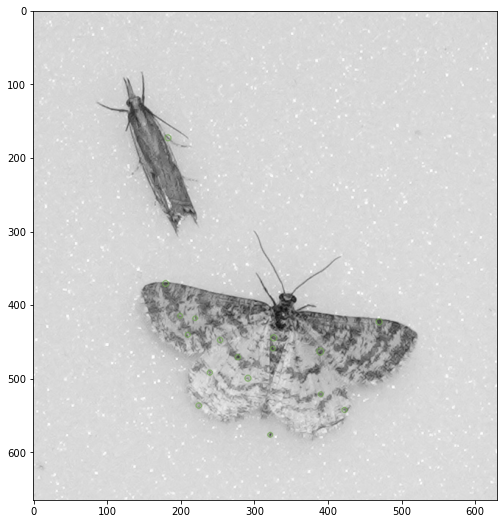

[<KeyPoint 0x7f1eac2373f0>, <KeyPoint 0x7f1ea64c5db0>, <KeyPoint 0x7f1eac1d80f0>, <KeyPoint 0x7f1eac0a5f60>, <KeyPoint 0x7f1eac0a5060>, <KeyPoint 0x7f1eac0a5360>, <KeyPoint 0x7f1eac0a5330>]


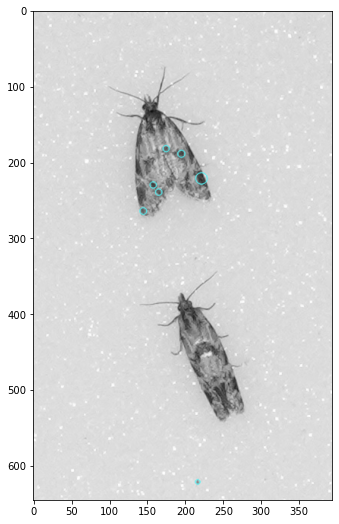

[<KeyPoint 0x7f1ea64c5fc0>, <KeyPoint 0x7f1ea64c5db0>]


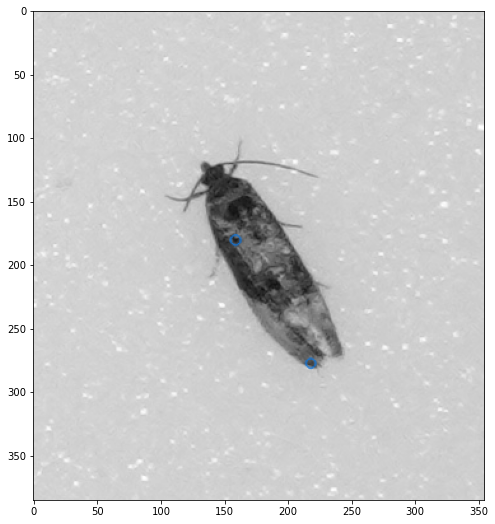

[<KeyPoint 0x7f1ea64c5db0>, <KeyPoint 0x7f1ea1acaa20>, <KeyPoint 0x7f1ea1acab10>]


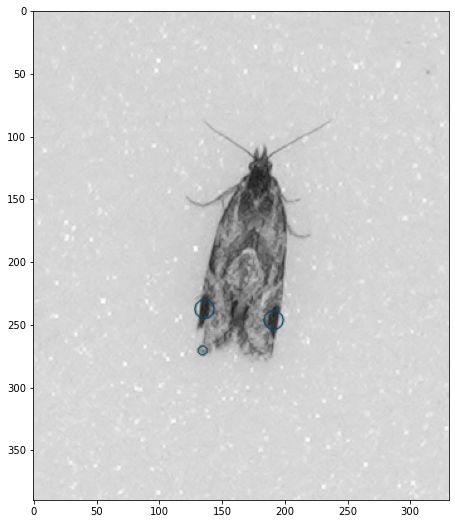

[<KeyPoint 0x7f1ea68c9d80>, <KeyPoint 0x7f1ea6875d20>, <KeyPoint 0x7f1ea1b78750>]


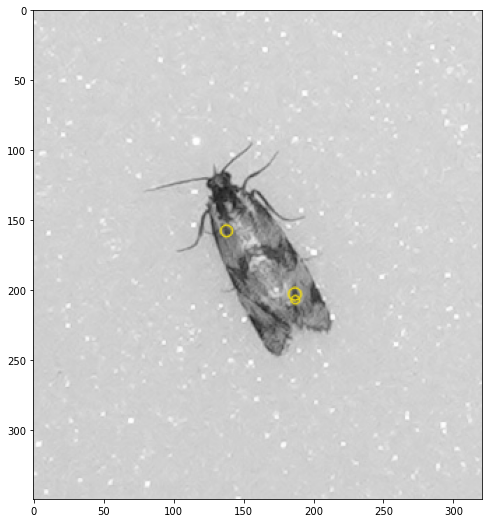

[]


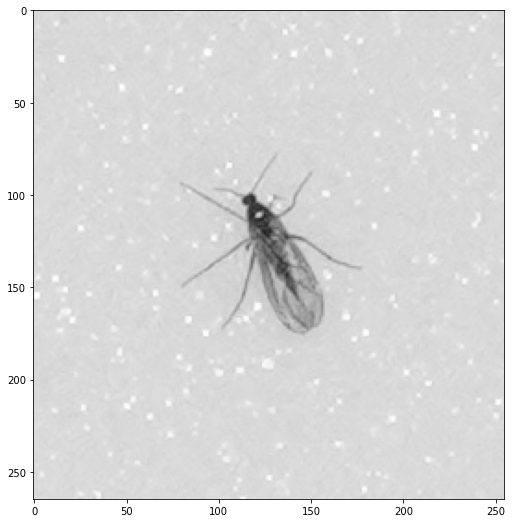

[<KeyPoint 0x7f1ea1e5e630>, <KeyPoint 0x7f1ea1e5e660>]


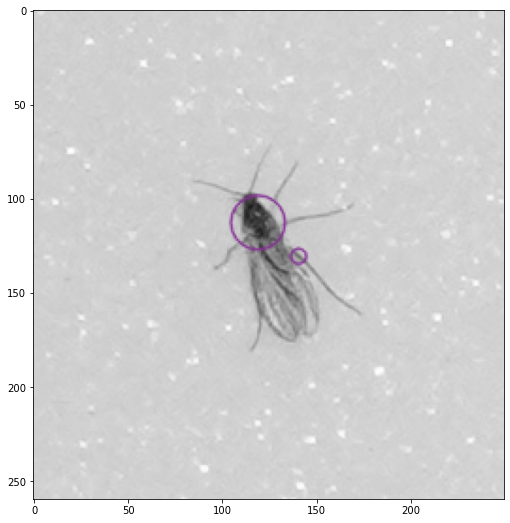

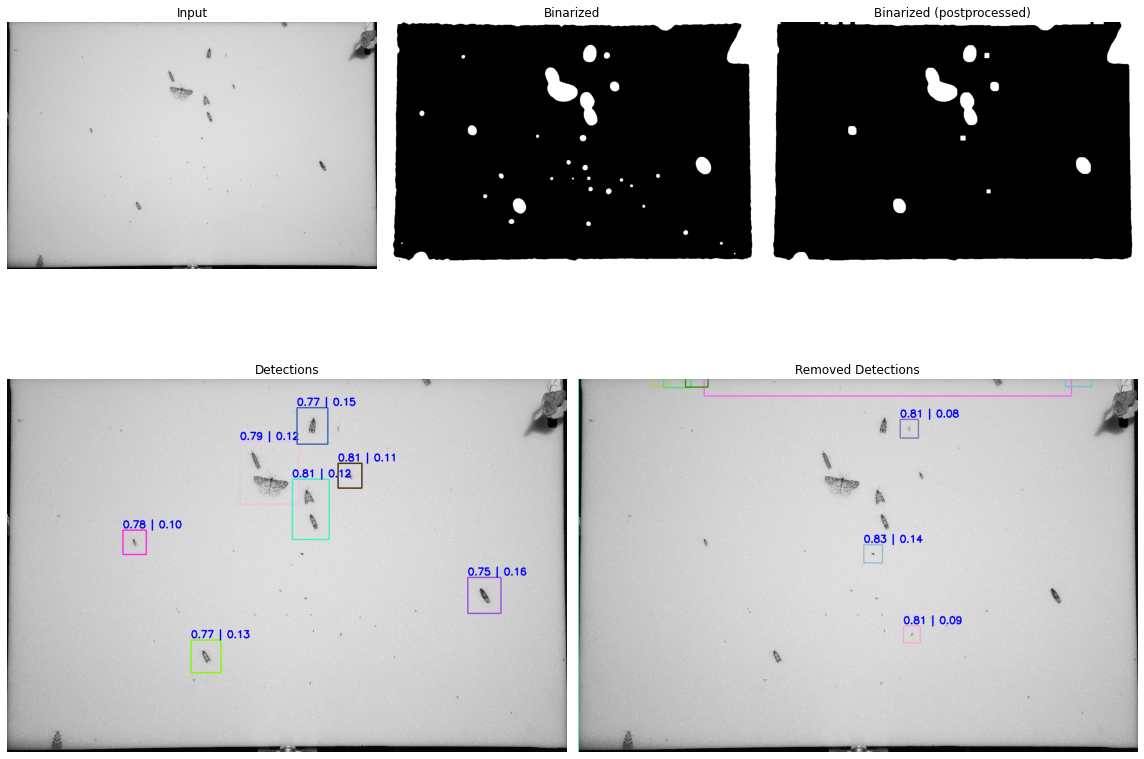

3.5641822916666666
[<KeyPoint 0x7f1ea1b7e1b0>, <KeyPoint 0x7f1ea1d41990>, <KeyPoint 0x7f1ea64e7a20>, <KeyPoint 0x7f1ea64e7ed0>, <KeyPoint 0x7f1ea64e7f00>, <KeyPoint 0x7f1ea64e77e0>, <KeyPoint 0x7f1ea64e77b0>, <KeyPoint 0x7f1ea64e7f30>, <KeyPoint 0x7f1ea64f16c0>, <KeyPoint 0x7f1ea64f12a0>, <KeyPoint 0x7f1ea64f12d0>, <KeyPoint 0x7f1ea64f1750>, <KeyPoint 0x7f1ea64f13c0>, <KeyPoint 0x7f1ea64f13f0>, <KeyPoint 0x7f1ea64f1ae0>, <KeyPoint 0x7f1ea64f1b10>, <KeyPoint 0x7f1ea64f1b40>, <KeyPoint 0x7f1ea64f1d80>, <KeyPoint 0x7f1ea64f1e70>, <KeyPoint 0x7f1ea64f1ea0>, <KeyPoint 0x7f1ea64f10c0>, <KeyPoint 0x7f1ea64f1180>, <KeyPoint 0x7f1ea64f11b0>, <KeyPoint 0x7f1ea64f1090>]


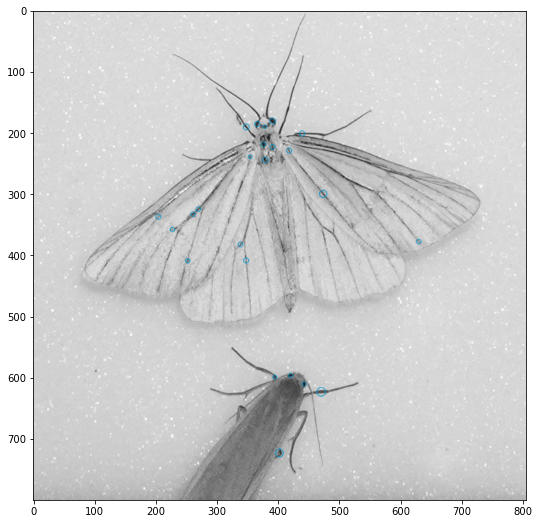

[<KeyPoint 0x7f1ea68e7d50>, <KeyPoint 0x7f1ea64e7a20>, <KeyPoint 0x7f1ea64e7ed0>, <KeyPoint 0x7f1ea64e7f00>]


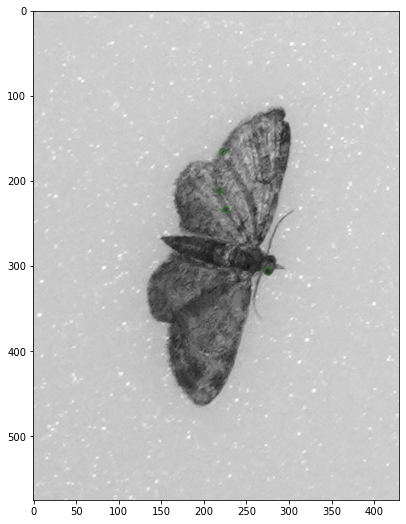

[<KeyPoint 0x7f1ea1b7e1b0>, <KeyPoint 0x7f1ea64c9db0>, <KeyPoint 0x7f1ea64e7a20>, <KeyPoint 0x7f1ea64e7ed0>, <KeyPoint 0x7f1ea64e7f00>, <KeyPoint 0x7f1ea68e7d50>, <KeyPoint 0x7f1ea697d600>, <KeyPoint 0x7f1ea697d6f0>, <KeyPoint 0x7f1ea697d720>, <KeyPoint 0x7f1ea697d570>, <KeyPoint 0x7f1ea697d660>, <KeyPoint 0x7f1ea697d690>, <KeyPoint 0x7f1ea697d360>, <KeyPoint 0x7f1ea697d390>, <KeyPoint 0x7f1ea697d3c0>, <KeyPoint 0x7f1ea69d2750>, <KeyPoint 0x7f1ea69d2780>, <KeyPoint 0x7f1ea69d27b0>, <KeyPoint 0x7f1ea6a58cf0>, <KeyPoint 0x7f1ea6a58e70>, <KeyPoint 0x7f1ea6a58d80>, <KeyPoint 0x7f1ea6a58d50>, <KeyPoint 0x7f1ea6b0dd50>]


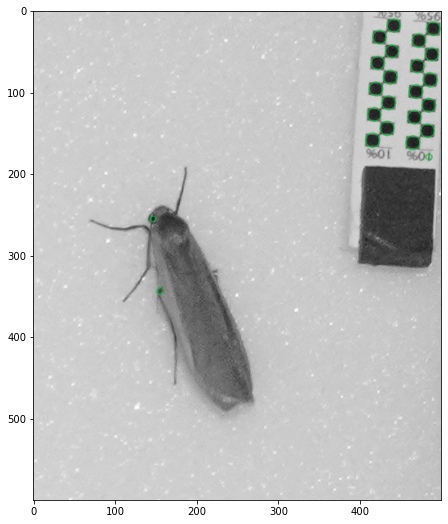

[<KeyPoint 0x7f1ea64c9f30>]


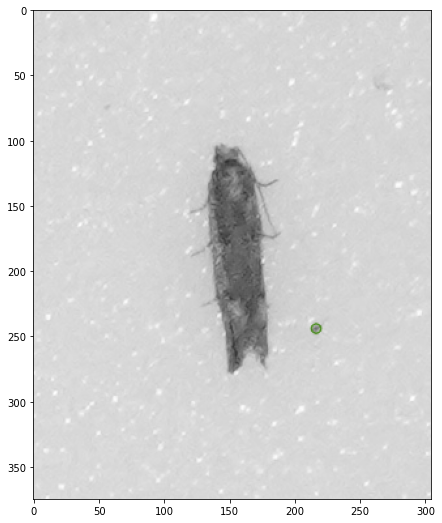

[<KeyPoint 0x7f1ea66c4b70>]


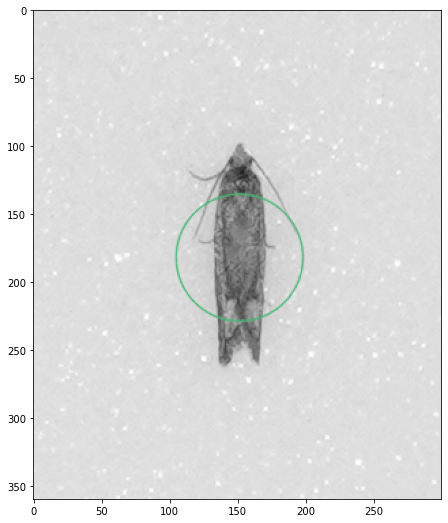

[]


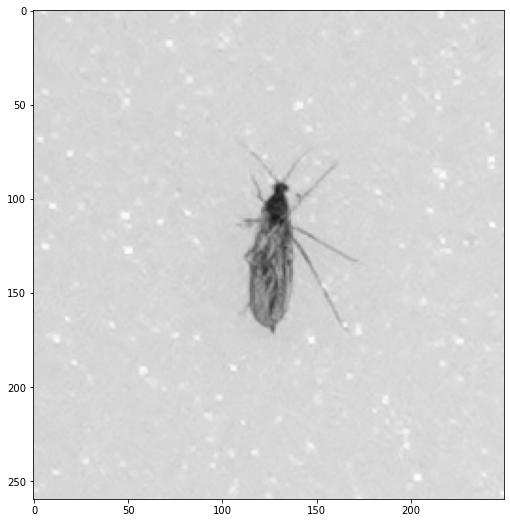

[]


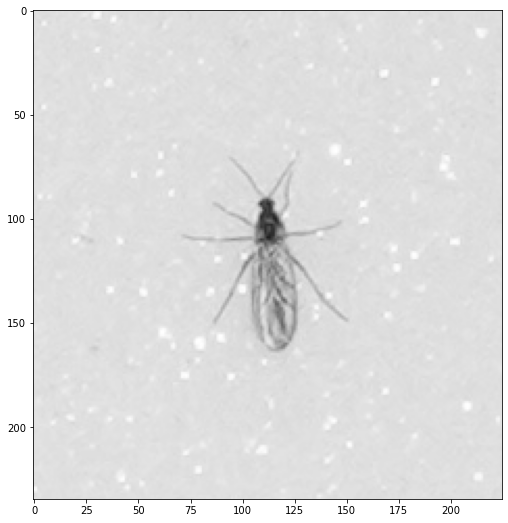

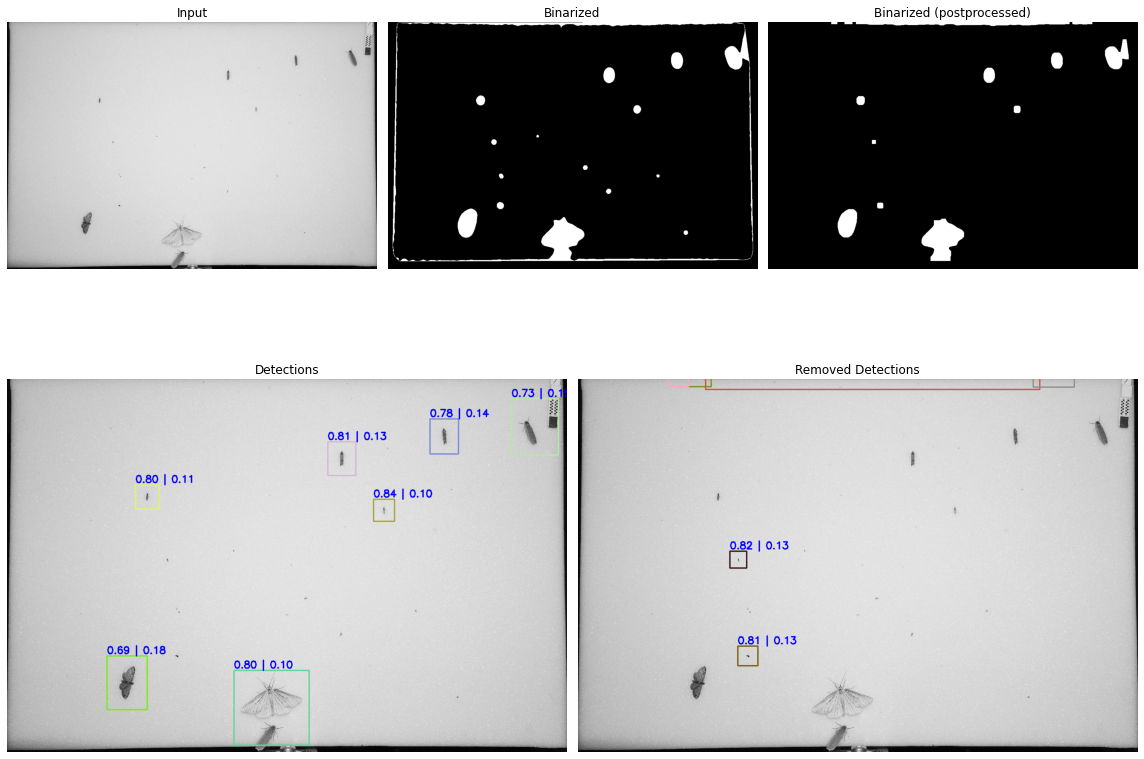

3.7757395833333334
[<KeyPoint 0x7f1ea6da4570>, <KeyPoint 0x7f1ea6da4810>, <KeyPoint 0x7f1ea6455870>, <KeyPoint 0x7f1ea6455960>]


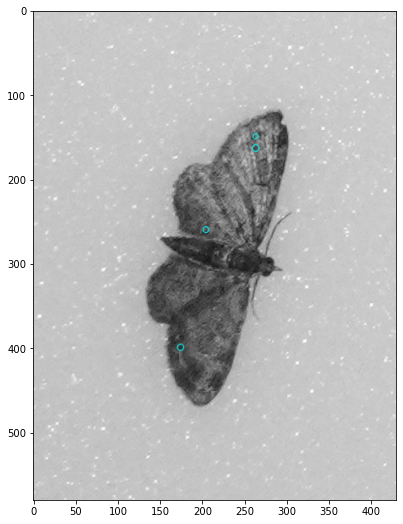

[<KeyPoint 0x7f1ea64437b0>, <KeyPoint 0x7f1ea6455870>, <KeyPoint 0x7f1ea6455960>, <KeyPoint 0x7f1ea699f090>, <KeyPoint 0x7f1ea6413d80>, <KeyPoint 0x7f1ea6413db0>, <KeyPoint 0x7f1ea6413f90>, <KeyPoint 0x7f1ea6413fc0>, <KeyPoint 0x7f1ea6413e70>, <KeyPoint 0x7f1ea6413ea0>, <KeyPoint 0x7f1ea6413ed0>, <KeyPoint 0x7f1ea646de10>, <KeyPoint 0x7f1ea646de40>, <KeyPoint 0x7f1ea646de70>, <KeyPoint 0x7f1ea646dcf0>, <KeyPoint 0x7f1ea646dd20>, <KeyPoint 0x7f1ea646dd50>, <KeyPoint 0x7f1ea6466a50>, <KeyPoint 0x7f1ea6466a80>, <KeyPoint 0x7f1ea6466ab0>, <KeyPoint 0x7f1ea6466930>]


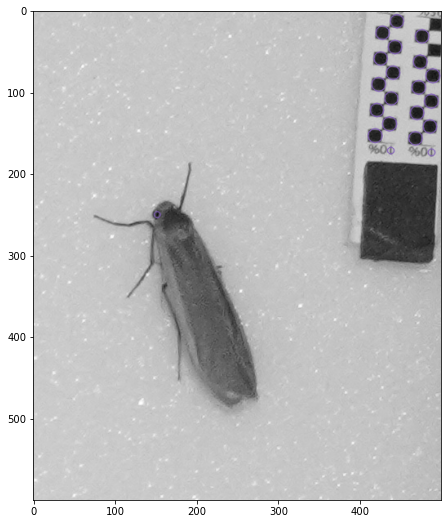

[<KeyPoint 0x7f1ea6455870>, <KeyPoint 0x7f1ea6455960>, <KeyPoint 0x7f1ea64437b0>, <KeyPoint 0x7f1ea646de10>, <KeyPoint 0x7f1ea646de40>]


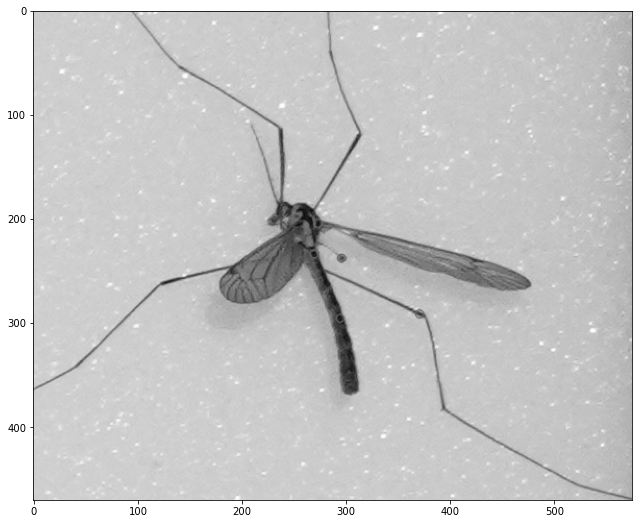

[<KeyPoint 0x7f1ea64437b0>]


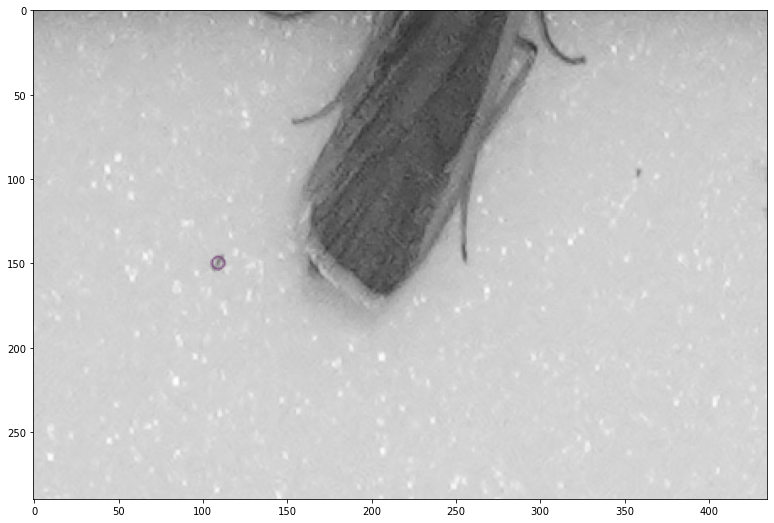

[<KeyPoint 0x7f1ea6455960>]


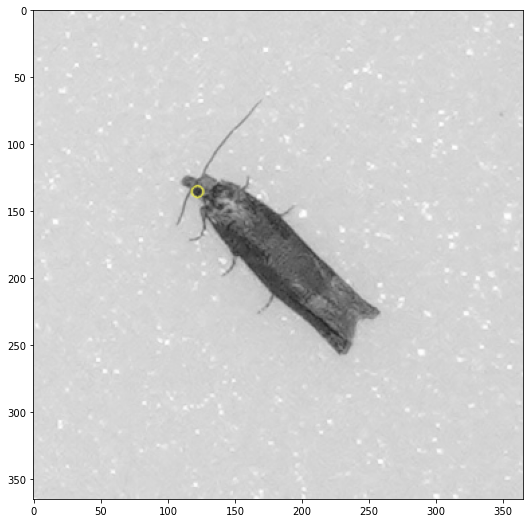

[]


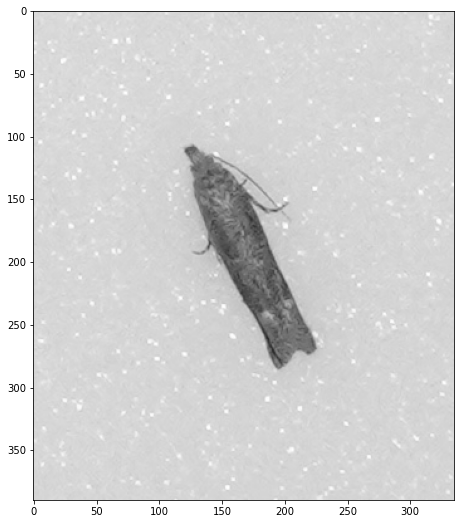

[<KeyPoint 0x7f1ea64437b0>]


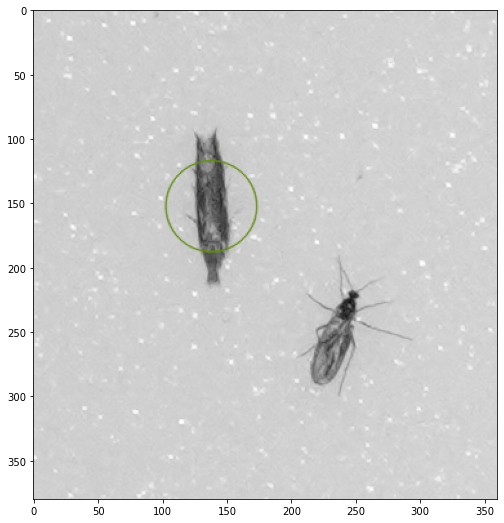

[<KeyPoint 0x7f1ea1dbe330>, <KeyPoint 0x7f1eac383d20>]


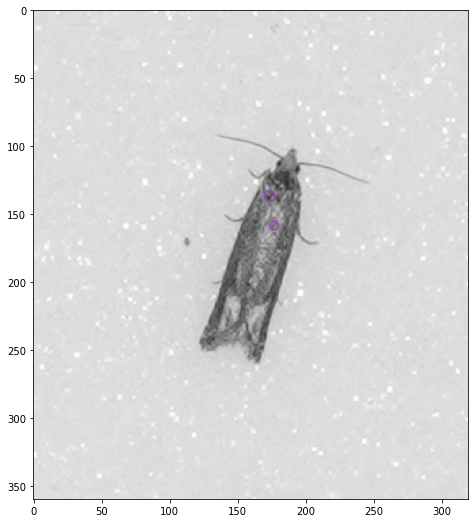

[<KeyPoint 0x7f1eac089540>, <KeyPoint 0x7f1eac06e540>, <KeyPoint 0x7f1eac1d8690>]


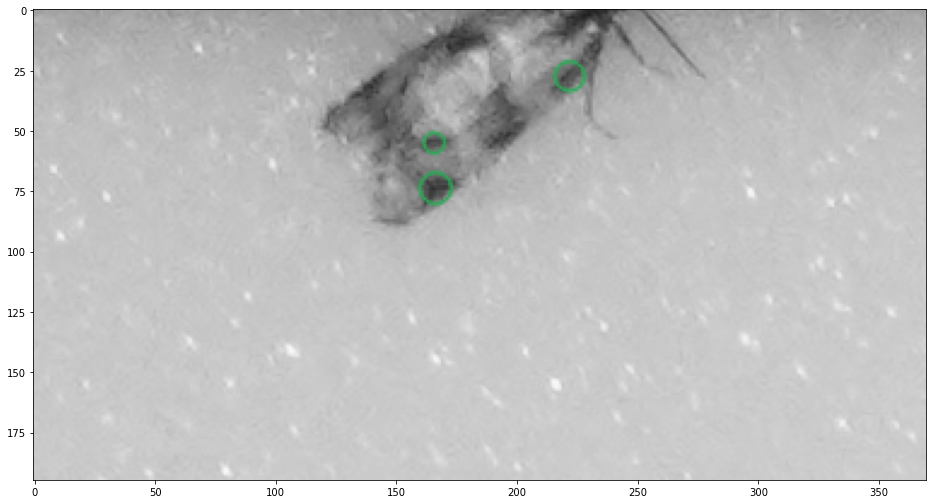

[]


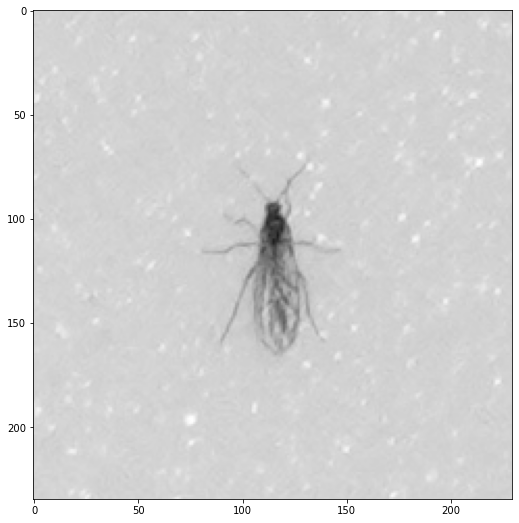

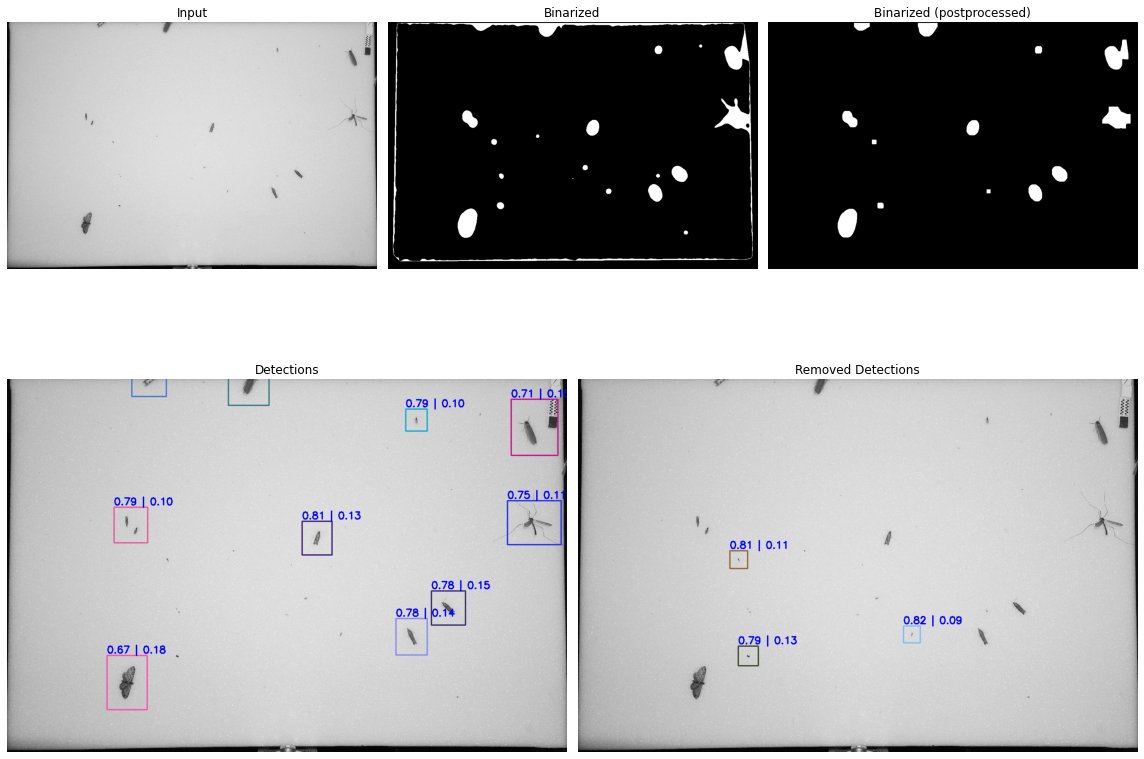

In [52]:
args = Args(
    scale=0.1,
    
    dilate_iterations=3,
    open_close=True,
    
    
    # bg_fg otsu gauss_local
    thresholding="bg_fg",
    
    location="brehm/2021-06-22_Weinschale-Ziegenhain",
    #location="brehm/2020-08-08_Strommast-Hahnengrund",
#     location="MCC/MCC_raw/val",
    
    equalize=False,
#     enlarge=-1,
    
    block_size_scale=0.2,
    sigma=-3,
    pad=False,
)
print(args)

# import os
# print("\n".join(sorted(os.listdir(args.root / "brehm"))))

main(args, N=3)